# Ticket to ride: analysis

## Introduction

In this project, I tried to estimate wich route are the most valuable in Ticket to Ride: Europe.

To understand the method taken, I will explain you briefely what is important to understand about this game.
In this game, you can earn points in roughly two ways:
- By building a new route
- By successfully linking two destinations

But building routes has a cost and you need turns of the game do build a new one.
I will try to quantify later every concept I introduced

## Importing the data

In [172]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

cities = pd.read_csv('cities.csv', index_col=0).to_dict(orient='index')
positions = {city: (pos['Longitude'], pos['Latitude'])
             for city, pos in cities.items()}
routes = pd.read_csv('routes.csv')
destinations = pd.read_csv('destinations.csv')

The following dataset contains information about the routes: the target and source city, the number of carriages needed to build, if its a tunnel ? a grey or colored route ? the number of engines needed.

In [173]:
routes.head()

,Source,Target,Carriages,Colored,Tunnel,Engine
0,Lisboa,Cadiz,2,True,False,0
1,Madrid,Lisboa,3,True,False,0
2,Madrid,Cadiz,3,True,False,0
3,Madrid,Pamplona,3,True,True,0
4,Madrid,Barcelona,2,True,False,0


The following dataset contains information about the destinations: the Source, the Target city and the points you can earn when you succedded to link the two cities

In [174]:
destinations.head()

,Source,Target,Points
0,Venezia,Constantinople,10
1,London,Wien,10
2,Angora,Kharkov,10
3,Essen,Kyiv,10
4,Riga,Bucuresti,10


Now I just print the graph of the map

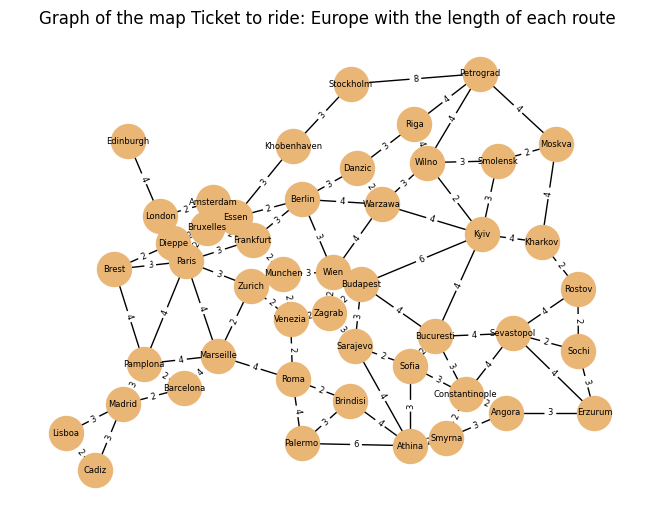

In [175]:
# Creation of the graph and its edges
G = nx.Graph()
for index, route in routes.iterrows():
    G.add_edge(route['Source'], route['Target'], carriages=route['Carriages'])

# Plot of the graph
nx.draw(G, positions, node_size=600, font_size=6,
        node_color='#eab676', with_labels=True)

# Adding the carriages on the graph
edge_labels = {(u, v): np.round(d['carriages'], 2)
               for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(
    G, positions, edge_labels=edge_labels, font_size=6, font_color='black', label_pos=0.5)
plt.title('Graph of the map Ticket to ride: Europe with the length of each route ')
plt.show()

## The proficiency of building a new route

### The cost of building a new route

In this part, I tried to evaluate the relative cost from building a new route according the characteristic of the route. It is a known fact that building a colored routes has a bigger cost than a grey route, a tunnel route has a bigger cost than a normal route, etc.
But can we quantify it ?
For each characteristic, I used different methods.

#### Tunnels

There are some tunnel routes, such as the route Zurich-Marseille

Quantifying the incresing of the cost of a tunnel is easy. The number of cards you need to add follows Binomial random variable $B(n,p)$ with:
- $n =$ number of carriages needed, 
- $p =$ probability of choosing the wrong carriage, so $1$ for the color of the route $+ 1$ for the engine color divided by $8$ the total number of colors. So $p=\frac{2}{8}=\frac{1}{4}$.

The expectancy is thus $E(X)= \frac{n}{4}$

So the incresing is $1+\frac{1}{4}$ times for a tunnel route than a normal one. This is a 25% increasing.

#### Necessary engines

There are some engines needed routes, such as the route Rome-Palermo

The number of engines needed varies. So I use the variable $r = \frac{number\ of\ engines\  needed}{number\ of\ total\ carriages}$

Given that in the ruel you can take one engine or two carriages, and givent tha on average you take one random card and one visible card, I estimated that an engine is equivalent to 1.5 normal carriage.

So the increasing is $1+0.5r$ times for a engine route than a normal one.

#### Grey route vs colored route

This characteristic was the most difficult for me. Because you need to add the strategy on the calculation. So I used a new python file to calculated empirically this value. 

My program plays a lot of turn with a strategy. For instance, If he needs to build a red and gold route, he vill take these cards if there is one or two visible.

The python file ```player-strategy-one-attempt.py``` shows how the game works.

```player-strategy-stats-color.py``` calculates for colored routes and ```player-strategy-stats-grey.py``` calculates for grey routes. 

By reading the results, I found that a grey route needs 1.3 less cost so 30% less.

#### Length of the route

I used the previous codes to determine the relative cost of the routes depending on its length.
The results are presented here (the values are normalized):
- 1 for a 1 carriage route
- 0.71 for a 2 carriage route
- 0.53 for a 3 carriage route
- 0.43 for a 4 carriage route
- 0.29 for a 6 carriage route
- 0.21 for a 8 carriage route


#### Conclusion about the cost

The cost is a function depending of the all previous features. I created the function ```cost``` which calculated the cost for a give routes considering its characteristics.
```cost_dict``` contains the cost for a normal route with a certain length.

In [176]:
cost_dict = {1:1, 2:0.71, 3:0.53,4:0.43,6:0.29,8:0.21}

def cost(carriages,colored,tunnel,engines):
    r_engines = engines/carriages
    loss_engines = 1+0.5*r_engines
    loss_tunnel = 1.25 if tunnel else 1
    gain_gray = 1.3 if not colored else 1
    inv_cost = cost_dict[carriages]*gain_gray/loss_engines/loss_tunnel
    return 1/inv_cost

### The gain of building a new route

The gain is given by the number of points you earn when you completed a new route. It depends on the length of the route.
- 1 point for a 1 carriage route
- 2 points for a 2 carriage route
- 4 points for a 3 carriage route
- 7 points for a 4 carriage route
- 13 points for a 6 carriage route
- 21 points for a 8 carriage route

```gain_dict``` contains the gain depending on it length.

In [177]:
gain_dict = {1:1,2:2,3:4,4:7,6:13,8:21}

### The proficency of a route

The proficency is given by the ratio $\frac{nb\ of\ points\ earned}{cost\ of\ the\ build}$

The function ```proficency``` calculates the proficency for a route considering all of its characteristics.

In [178]:
def proficency(carriages,colored,tunnel,engines):
    cost_value = cost(carriages,colored,tunnel,engines)
    gain_value = gain_dict[carriages]
    return gain_value/cost_value

Now I calculate the proficency for all the routes and I plot the graph

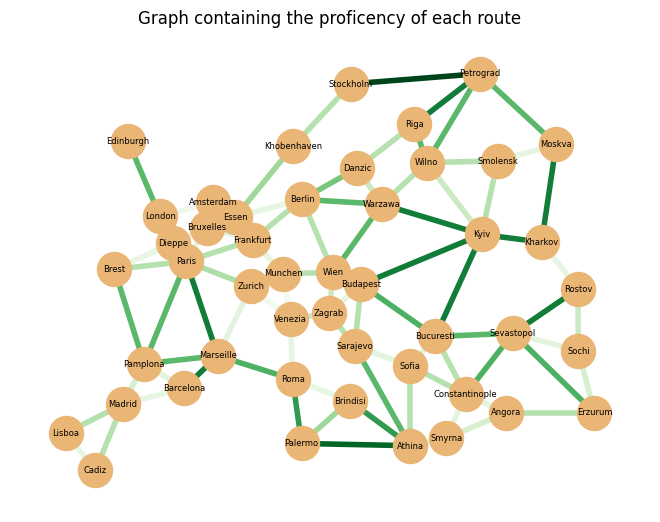

In [179]:
# Creation of the graph and calculation fo the proficency
G = nx.Graph()
for index, route in routes.iterrows():
    proficency_value = proficency(route['Carriages'], route['Colored'],
                                  route['Tunnel'], route['Engine'])
    G.add_edge(route['Source'], route['Target'], proficency=proficency_value)

# Normalization
max_proficency = max(nx.get_edge_attributes(G, "proficency").values())
for u, v, attrs in G.edges(data=True):
    attrs['proficency'] = attrs['proficency']/max_proficency

# Plot of the graph with edge colors based on 'proficency'
edge_values = [attrs['proficency'] for _, _, attrs in G.edges(data=True)]

# Plot the graph with the colormap
options = {
    "node_size": 600,
    "font_size": 6,
    "node_color": "#eab676",
    "edge_color": edge_values,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
}
nx.draw(G, positions, **options)

# Show the plot
plt.title('Graph containing the proficency of each route')
plt.show()

## The utility of building a new route

Building a new route allows the player to possibly link two destinations mentionned in a card *destination.*

But some routes are better suited to linking two destination cards. For instance: Paris-Frankfurt is more suited than Cadiz-Lisboa. But can we quantify it ?

The method taken is the following: I consider the graph with weights equals to the cost of a route.
I consider all the destinations cards in ```destinations.csv```.
- For each destination:
    - I calculate the shortest distance (sum of the weight of the shortest path) of the two cities ```min_dist```.
    - For each edge: I calculate the shortest distance of the two cities in the destination card given that the path must pass on this edge. I get ```opt_dist_edge```. The utility of this edge for this destination card is the function depending on the ratio $\frac{opt\ dist\ edge}{min\ dist}$ and the points of this destination card.

The previous function is called ```utility``` and it is given by $utility = e^{\frac{opt\ dist\ edge}{min\ dist}}.\ points$
For the calculation of minimal distances, I use Dijkstra algorithm.

The definition of the function ```utility``` is given there:

In [180]:
def utility(min_dist, opt_dist, points):
    return np.exp(-opt_dist/min_dist)*points

I first calculate the cost of each route

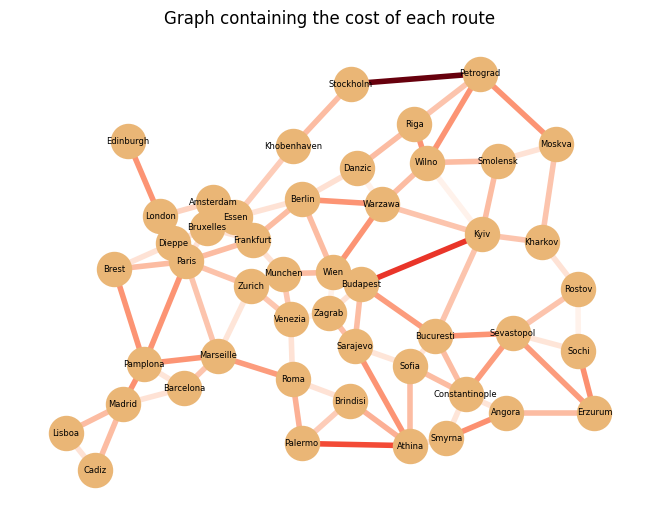

In [181]:
# Creation of the graph and calculation fo the proficency
G = nx.Graph()
for index, route in routes.iterrows():
    cost_value = cost(route['Carriages'], route['Colored'],
                                  route['Tunnel'], route['Engine'])
    G.add_edge(route['Source'], route['Target'], cost=cost_value, utility=0)

# Normalization
max_cost = max(nx.get_edge_attributes(G, "cost").values())
for u, v, attrs in G.edges(data=True):
    attrs['cost'] = attrs['cost']/max_cost

# Plot of the graph with edge colors based on 'proficency'
edge_values = [attrs['cost'] for _, _, attrs in G.edges(data=True)]

# Plot the graph with the colormap
options = {
    "node_size": 600,
    "font_size": 6,
    "node_color": "#eab676",
    "edge_color": edge_values,
    "width": 4,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
}
nx.draw(G, positions, **options)

# Show the plot
plt.title('Graph containing the cost of each route')
plt.show()

Then I calculate the sum of the utility of each edge for each destination and normalize. 

In [182]:
for _ , row in destinations.iterrows():
    source = row['Source']
    target = row['Target']
    points = row['Points']
    min_lengths_source, _ = nx.single_source_dijkstra(G, source=source, weight="cost")
    min_lengths_target, _ = nx.single_source_dijkstra(G, source=target, weight="cost")
    min_dist = min_lengths_source[target]
    for u, v, attrs in G.edges(data=True):
        opt_dist_edge = min(min_lengths_source[u]+min_lengths_target[v],min_lengths_source[v]+min_lengths_target[u])+attrs['cost']
        attrs['utility'] = attrs['utility'] + utility(min_dist, opt_dist_edge, points)
    
max_utility = max(nx.get_edge_attributes(G, "utility").values())
for u, v, attrs in G.edges(data=True):
    attrs['utility'] = attrs['utility']/max_utility

I plot the graph of utility

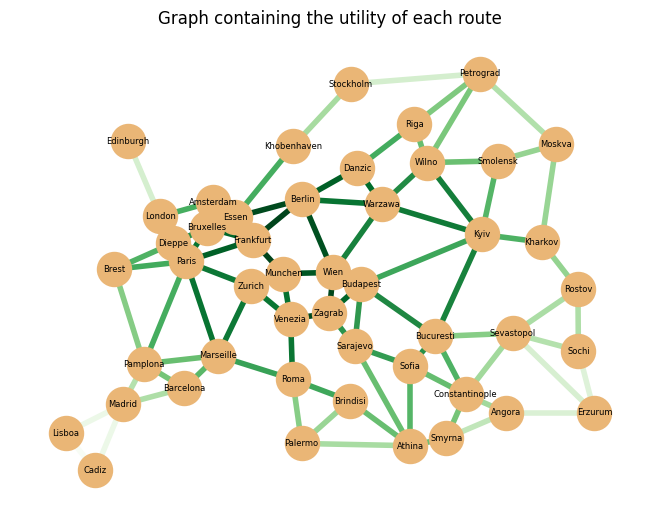

In [183]:
# Plot of the graph with edge colors based on 'proficency'
edge_values = [attrs['utility'] for _, _, attrs in G.edges(data=True)]

# Plot the graph with the colormap
options = {
    "node_size": 600,
    "font_size": 6,
    "node_color": "#eab676",
    "edge_color": edge_values,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
}
nx.draw(G, positions, **options)

# Show the plot
plt.title('Graph containing the utility of each route')
plt.show()

The results seems to be correct because the routes in the center of the map are more useful than the one in the edge of the graph. Here are the result of our example:

In [184]:
lisboacadiz = G.get_edge_data("Lisboa", "Cadiz")['utility']
print(f"Utility of the route Lisboa-Cadiz: {np.round(lisboacadiz,2)}")

parisfrankfurt = G.get_edge_data("Paris", "Frankfurt")['utility']
print(f"Utility of the route Paris-Frankfurt: {np.round(parisfrankfurt,2)}")

Utility of the route Lisboa-Cadiz: 0.34
Utility of the route Paris-Frankfurt: 0.94


## Valuability of a route

The valuability of a route quantifies if a route is important to build beceause it will globally earn points. It is a combination of the proficency and the utility.

Actually, in a game, I estimated that 60% of the points comes from building new routes and 40% comes from completing destinations cards (the other source of points are not considerated for simplification).
Thus the valuability is given by:

$$valuability = 0.6\ .\ proficency + 0.4\ .\ utility$$

The final code is given below:

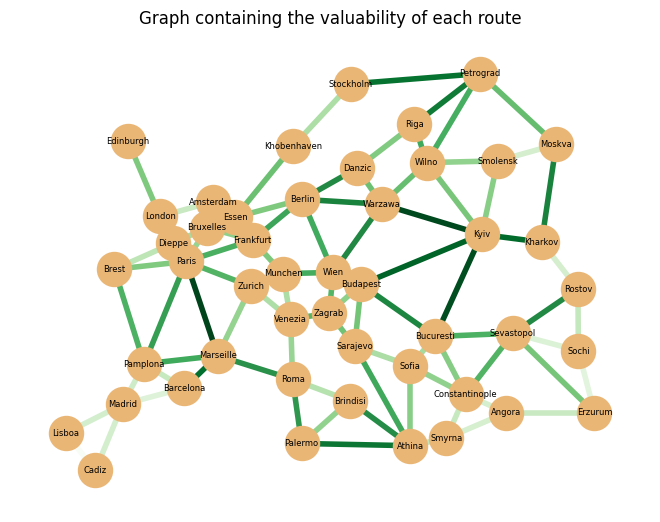

In [185]:
# Creation of the graph and calculation fo the proficency
G = nx.Graph()
for index, route in routes.iterrows():
    cost_value = cost(route['Carriages'], route['Colored'],
                                  route['Tunnel'], route['Engine'])
    proficency_value = proficency(route['Carriages'], route['Colored'],
                                  route['Tunnel'], route['Engine'])
    G.add_edge(route['Source'], route['Target'], cost=cost_value,proficency=proficency_value, utility=0, valuability=0)

# Nomalization
max_cost = max(nx.get_edge_attributes(G, "cost").values())
max_proficency = max(nx.get_edge_attributes(G, "cost").values())
for u, v, attrs in G.edges(data=True):
    attrs['cost'] = attrs['cost']/max_cost
    attrs['proficency'] = attrs['proficency']/max_proficency

# Calculus of the utility
for _ , row in destinations.iterrows():
    source = row['Source']
    target = row['Target']
    points = row['Points']
    min_lengths_source, _ = nx.single_source_dijkstra(G, source=source, weight="cost")
    min_lengths_target, _ = nx.single_source_dijkstra(G, source=target, weight="cost")
    min_dist = min_lengths_source[target]
    for u, v, attrs in G.edges(data=True):
        opt_dist_edge = min(min_lengths_source[u]+min_lengths_target[v],min_lengths_source[v]+min_lengths_target[u])+attrs['cost']
        attrs['utility'] = attrs['utility'] + utility(min_dist, opt_dist_edge, points)

# Normalization 
max_utility = max(nx.get_edge_attributes(G, "utility").values())
for u, v, attrs in G.edges(data=True):
    attrs['utility'] = attrs['utility']/max_utility

# Calculus of valuability
for u, v, attrs in G.edges(data=True):
    attrs['valuability'] = 0.6*attrs['proficency'] + 0.4*attrs['utility']

# Plot of the graph with edge colors based on 'proficency'
edge_values = [attrs['valuability'] for _, _, attrs in G.edges(data=True)]

# Plot the graph with the colormap
options = {
    "node_size": 600,
    "font_size": 6,
    "node_color": "#eab676",
    "edge_color": edge_values,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
}
nx.draw(G, positions, **options)

# Show the plot
plt.title('Graph containing the valuability of each route')
plt.show()

## Lets create the best network!

Now we have all the keys to create the best theoretical network in the case that we have acess to all the destination cards.

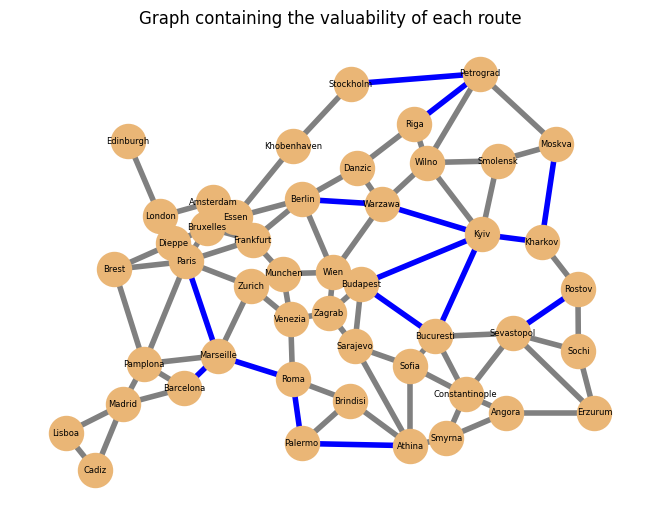

In [186]:
def choose_best_route(G: nx.graph):
    return max(G.edges(data=True), key=lambda x: x[2]['valuability'] if not x[2]['selected'] else 0)[0:2]

def recalculate_graph(G : nx.graph, built_routes:list):
    for u, v, attrs in G.edges(data=True):
        if (u,v) in built_routes:
            attrs['cost'] = 0
            attrs['proficency'] = 0
            attrs['selected'] = 1
        else :
            attrs['selected'] = 0
    for _ , row in destinations.iterrows():
        source = row['Source']
        target = row['Target']
        points = row['Points']
        min_lengths_source, _ = nx.single_source_dijkstra(G, source=source, weight="cost")
        min_lengths_target, _ = nx.single_source_dijkstra(G, source=target, weight="cost")
        min_dist = min_lengths_source[target]
        if min_dist == 0:
            continue
        for u, v, attrs in G.edges(data=True):
            opt_dist_edge = min(min_lengths_source[u]+min_lengths_target[v],min_lengths_source[v]+min_lengths_target[u])+attrs['cost']
            attrs['utility'] = attrs['utility'] + utility(min_dist, opt_dist_edge, points)
    
    # Normalization 
    max_utility = max(nx.get_edge_attributes(G, "utility").values())
    for u, v, attrs in G.edges(data=True):
        attrs['utility'] = attrs['utility']/max_utility

    # Calculus of valuability
    for u, v, attrs in G.edges(data=True):
        attrs['valuability'] = 0.6*attrs['proficency'] + 0.4*attrs['utility']
    return G

G = recalculate_graph(G,[])
built_routes = []
for i in range(15) :
    built_routes.append(choose_best_route(G))
    G = recalculate_graph(G, built_routes)

# Plot of the graph with edge colors based on 'proficency'
edge_values = ["blue" if attrs['selected'] == 1 else "gray" for _, _, attrs in G.edges(data=True)]

# Plot the graph with the colormap
options = {
    "node_size": 600,
    "font_size": 6,
    "node_color": "#eab676",
    "edge_color": edge_values,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
}
nx.draw(G, positions, **options)

# Show the plot
plt.title('Graph containing the valuability of each route')
plt.show()
    